# Digit recognition with Pytorch

This notebook's goal is to recognize digit using Pytorch. 

In [2]:
import torch
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn

## Preparing the data

In [3]:
data = EMNIST('/content/sample_data', split = 'letters', download = True, train = True, transform = transforms.Compose([transforms.ToTensor()]))
data_val = EMNIST('/content/sample_data', split = 'letters', download = True, train = False, transform = transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting /content/sample_data/EMNIST/raw/gzip.zip to /content/sample_data/EMNIST/raw


The data is not normalized so in order to do that, mean and standard deviation should be calculated.

In [4]:
(type(data), type(data_val))

(torchvision.datasets.mnist.EMNIST, torchvision.datasets.mnist.EMNIST)

data and data_val are datasets so it will be a good idea to transform it into a Tensor looping over the dataset concatenating a sequence of tensor along a new dimension.

In [5]:
images = torch.stack([img for img, _ in data],dim=3)
(images.shape, type(images))

(torch.Size([1, 28, 28, 124800]), torch.Tensor)

Calculate the mean and standard deviation

In [6]:
mean = images.view(1,-1).mean(dim=1)
std = images.view(1,-1).std(dim=1)
(mean, std)

(tensor([0.1722]), tensor([0.3309]))

Now we can import the data and normalize it using means and std calculated before

In [7]:
data_train = EMNIST('/content/sample_data', split = 'letters', download = True, train = True, transform = transforms.Compose([transforms.ToTensor(), 
                                                                                                                        transforms.Normalize((0.1722), (0.3309))]))
data_val = EMNIST('/content/sample_data', split = 'letters', download = True, train = False, transform = transforms.Compose([transforms.ToTensor(),
                                                                                                                             transforms.Normalize((0.1722), (0.3309))]))

View a few examples of the dataset

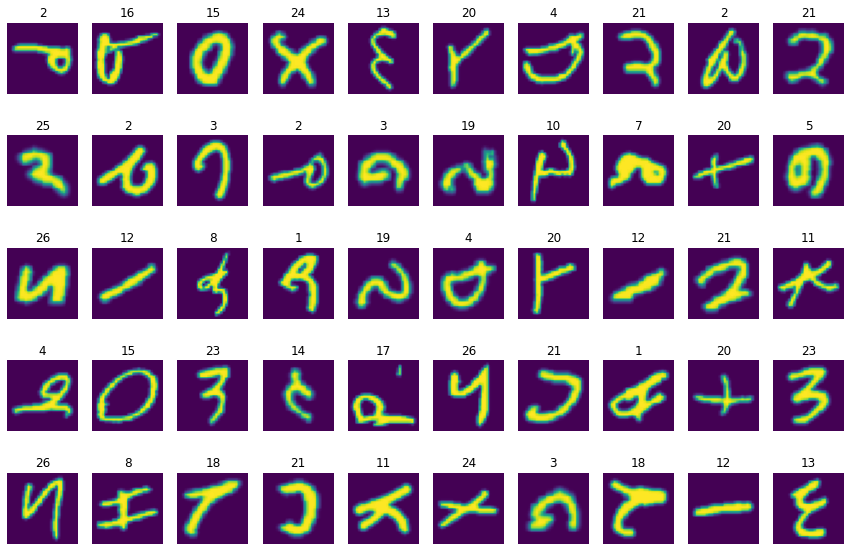

In [8]:
fig = plt.figure(figsize = (15,10))
cols, rows = 10 , 5
for i in range(1,cols*rows+1):
  idx = torch.randint(len(data), size = (1,)).item()
  img, label = data[idx]
  fig.add_subplot(rows,cols, i)
  plt.title(label)
  plt.imshow(img.squeeze())
  plt.axis("off")
plt.show()

Feed the Dataloader

In [33]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size = 32, shuffle = True, num_workers=1)
val_loader = torch.utils.data.DataLoader(data_val, batch_size = 32, shuffle = False, num_workers=1)

## Build the model


In [74]:
class NN(nn.Module):

  def __init__(self):
    super(NN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels=16, kernel_size=5, stride =1, padding = 2)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride =1, padding=2)
    self.layer1 = nn.Sequential(self.conv1, nn.ReLU(), nn.MaxPool2d(kernel_size=2))
    self.layer2 = nn.Sequential(self.conv2, nn.ReLU(), nn.MaxPool2d(kernel_size=2))
    self.out = nn.Linear(32*7*7, 26)
  
  def forward(self,x):
    x = self.layer1(x)
    x=self.layer2(x)
    x = x.view(x.size(0), -1)
    output=self.out(x)
    return output

In [75]:
model = NN()
print(model)

NN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=26, bias=True)
)


Test if the model is outputing the correct shape

In [83]:
img, _ = next(iter(train_loader))
img = img[0]
guess = model(img.unsqueeze(0))
print(guess.shape)

torch.Size([1, 26])


Model summary

In [85]:
from torchsummary import summary
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
            Conv2d-2           [-1, 16, 28, 28]             416
              ReLU-3           [-1, 16, 28, 28]               0
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]          12,832
            Conv2d-6           [-1, 32, 14, 14]          12,832
              ReLU-7           [-1, 32, 14, 14]               0
         MaxPool2d-8             [-1, 32, 7, 7]               0
            Linear-9                   [-1, 26]          40,794
Total params: 67,290
Trainable params: 67,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.47
Params size (MB): 0.26
Estimated Total Size (MB): 0.73
---------------------------------------------

## Training loop

In [124]:
def training_loop(epochs, model, loss_fn, optimiser, train_loader):
  model.train()
  max_step = len(train_loader)

  for e in range(1, epochs+1):
    for i, (imgs, labels) in enumerate(train_loader):
      #move forward
      out = model(imgs)
      #calculate loss
      loss = loss_fn(out, labels)
      #reset gradients
      optimiser.zero_grad()
      #move back
      loss.backward()
      #update weights
      optimiser.step()
      
      if (i+1) % (epochs/10) == 0:
        print('Epoch [{}/{}], Step [{}/{}], Loss:{ }'.format(e, epochs,i+1, max_step, loss.item()))


In [125]:
model = NN()
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(20, model, loss_fn, optim, train_loader)

IndexError: ignored

## Validation

In [127]:
def validate(model, train_loader, val_loader):       
    model.eval() # set to eval mode to avoid batchnorm
    with torch.no_grad(): # avoid calculating gradients
        correct, total = 0, 0
        for images, labels in val_loader:
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    print('VALIDATION SET ACCURACY: {}'.format(accuracy))
    
validate(model, train_loader, val_loader)

VALIDATION SET ACCURACY: 0.0
